In [52]:
import numpy as np
import caveclient
import scipy
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import tqdm
import os
import networkx as nx
from dotmotif import Motif, GrandIsoExecutor
from dotmotif.ingest import CSVEdgelistConverter
from scipy import stats

In [53]:
raw_data = pd.read_feather('../data/Microns In Vivo Correlation Data v2/cell_cell_correlations.feather')
raw_data = raw_data.drop_duplicates(subset=['pt_root_id_1', 'pt_root_id_2'], keep='first')
# raw_data.columns
raw_data['pt_root_id_1'].dtype
# drop duplicates

raw_data = pd.concat([raw_data, raw_data.rename({'pt_root_id_1': 'pt_root_id_2', 'pt_root_id_2': 'pt_root_id_1'})]).reset_index(drop=True)
raw_data

,pt_root_id_1,pt_root_id_2,corr,scan_idx,session
0,864691135348268503,864691135700505634,0.018631,7,4
1,864691135348268503,864691135776919981,-0.005178,7,4
2,864691135348268503,864691135472842290,0.006708,7,4
3,864691135348268503,864691135349237975,0.020941,7,4
4,864691135345445279,864691135348268503,0.008743,7,4
...,...,...,...,...,...
13007153,864691135715713562,864691136267470324,0.058886,3,7
13007154,864691135715713562,864691135778113213,0.020464,3,7
13007155,864691135697182106,864691136267470324,0.011063,3,7
13007156,864691135697182106,864691135778113213,-0.029825,3,7


In [54]:
import platform
import os

platstring = platform.platform()
if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2023/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on Code Ocean
    data_root = "../data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2023/"
    
data_dir = os.path.join(data_root, 'microns_in_silico')

# you can just override this if the location of the data varies
# data_dir = '/Users/forrestc/Downloads/microns_in_silico/'

In [55]:
# we are going to load up the data and prepare the dataframe like we did 
# in class but with fewer comments

# load up the in-silico responses as a pandas dataframe from a numpy array 
resp=pd.DataFrame(np.load(os.path.join(data_dir, 'nat_resp.npy')))

# load up the csv of metadata about the 104171 units
units_df = pd.read_csv(os.path.join(data_dir, 'nat_unit.csv'))

# set the index to the be the row_idx of the units_df
resp.index = units_df['row_idx']

# if we are on code ocean, the CAVEsetup helped you make your token an environment variable
if 'amzn' in platstring:
    client= caveclient.CAVEclient('minnie65_public', auth_token=os.environ['API_SECRET'])
else:
    # otherwise if you are local, then it should be saved to a file in your harddrive 
    # that the caveclient knows where to read.
    client= caveclient.CAVEclient('minnie65_public')

# lets pull out the manual coregistered neurons
# desired_resolution describes how many nanometers you want each unit to be
# so 1000,1000,1000 gives positions in microns for x,y and z
coreg_df = client.materialize.query_table('coregistration_manual_v3', desired_resolution=[1000,1000,1000])

# lets merge these dataframes so we get the row_idx of each coregistered unit
# we merge on the corresponding columns, however scan was called something
# slightly different in one csv vs the CAVE table
coreg_in_silico=pd.merge(units_df, coreg_df, 
         left_on=['scan_session', 'scan_idx', 'unit_id'],
          right_on=['session','scan_idx', 'unit_id'])
# reset the index to make sure that we have the index
coreg_in_silico.reset_index(inplace=True)
print(coreg_in_silico.shape)

# this will pull out the responses to the coregistered units
# by using the row_idx that was provided in the metadata
coreg_resp = resp.loc[coreg_in_silico.row_idx,:]

# now with a reduced set of units, we can calculate the Pearson correlation
# between their responses
corr_M = np.corrcoef(coreg_resp.values)

ct_df = client.materialize.query_table('aibs_soma_nuc_exc_mtype_preds_v117')
# lets merge it on the coregistered cells with in silico responses
# we will use the segment version is (pt_root_id) to do this
ct_merge_df=pd.merge(coreg_in_silico.reset_index(),
                     ct_df[['pt_root_id', 'id_ref', 'cell_type']],
                     on='pt_root_id')

# lets pull all the neurons where we can trust the axons
# as being reasonably well reconstructed
prf_df=client.materialize.query_table('proofreading_status_public_release', 
                                      filter_in_dict={'status_axon': ['extended', 'clean']})
print(prf_df.shape)
# how many of these are coregistered?
clean_coreg_df = pd.merge(prf_df, coreg_in_silico, on='pt_root_id')

# we need this code to work in solutions directory
# and one up..
workshop2file = 'all_prf_coreg_conn_v661.pkl'
all_syn_df = pd.read_pickle(workshop2file)

nuc_df = client.materialize.query_view('nucleus_detection_lookup_v1', 
                                        select_columns = ['id', 'pt_root_id', 'pt_position'],
                                        desired_resolution=[1000,1000,1000])

# lets merge on the pre and post-synaptic positions of these connections

# renaming the positions as pre and post depending on how we did the merge
# and drop the duplicate id columns
all_syn_dfm=all_syn_df.merge(nuc_df[['id', 'pt_position']], left_on='pre_nuc_id', right_on='id')\
.rename({'pt_position':'pre_pt_position'}, axis=1)\
.merge(nuc_df[['id', 'pt_position']], left_on='post_nuc_id', right_on='id')\
.rename({'pt_position':'post_pt_position'}, axis=1)\
.drop(['id_x', 'id_y'], axis=1)

# now lets merge in the neurons that are coregistered with responses

# we have to drop duplicates to avoid the few cells that were coregistered twice 
# being double counted
all_syn_dfm2=all_syn_dfm.merge(coreg_in_silico[['index','target_id', 'scan_session', 'scan_idx', 'field','unit_id', 'score', 'residual']],
                  left_on='pre_nuc_id', 
                  right_on='target_id')\
.merge(coreg_in_silico[['index','target_id', 'scan_session', 'scan_idx', 'field','unit_id','score', 'residual']],
                  left_on='post_nuc_id', 
                  right_on='target_id',
                  suffixes=['_pre', '_post'])\
.drop(['target_id_pre', 'target_id_post'],axis=1)\
.drop_duplicates(subset=['pre_nuc_id', 'post_nuc_id'])
all_syn_dfm2

# now use fancy indexing to pull out the correlation associated with each of these connections
all_syn_dfm2['C']=corr_M[all_syn_dfm2.index_pre, all_syn_dfm2.index_post]


# now lets merge in our cell type calls
# by using suffixes we will name the pre and post synaptic cell type 
# differently
all_syn_dfm3=all_syn_dfm2.merge(ct_df[['target_id', 'cell_type']],
                  left_on='pre_nuc_id', 
                  right_on='target_id')\
.merge(ct_df[['target_id', 'cell_type']],
                  left_on='post_nuc_id', 
                  right_on='target_id',
                  suffixes=['_pre', '_post'])\
.drop(['target_id_pre', 'target_id_post'],axis=1)\
.drop_duplicates(subset=['pre_nuc_id', 'post_nuc_id'])

(12094, 23)
(1051, 10)


In [56]:
all_syn_dfm2.index_pre

0         1732
1         9201
2        10852
4         2145
5         2091
         ...  
36266      323
36270      323
36278      394
36282     8949
36283     8949
Name: index_pre, Length: 24782, dtype: int64

In [57]:
resp

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
row_idx,,,,,,,,,,,,,,,,,,,,,
0,9.819719,9.572107,9.575624,9.747010,9.971255,9.851794,10.146152,10.441845,10.554578,10.590077,...,10.074213,9.852283,9.957593,10.008598,9.929258,9.856516,9.963867,9.899036,9.846794,9.755130
1,5.824135,5.336558,5.128190,5.203142,5.506340,5.930792,6.528087,6.857086,7.117443,7.385743,...,5.238009,5.207496,5.200150,5.162911,5.277632,5.155036,5.286361,5.119339,5.125288,5.078022
2,5.691068,5.529594,5.803073,6.178924,6.443235,6.469791,6.654843,6.811019,6.661856,6.376816,...,5.361619,5.108631,4.880289,4.721966,4.654217,4.591662,4.486180,4.514648,4.727315,5.012149
3,3.548255,3.565851,3.518249,3.360956,2.990964,2.775848,2.678332,2.665106,2.672216,2.675659,...,3.610325,3.597228,3.585626,3.641256,3.775688,3.861930,3.925865,3.802548,3.864862,3.896344
4,6.361384,6.344265,6.517450,6.768298,6.822587,6.806442,7.249547,7.614173,7.614393,7.706423,...,6.779241,6.837814,6.838259,6.975827,6.713204,6.575862,6.436296,6.197456,6.013506,5.949809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104166,7.371026,7.391239,7.418334,7.503781,7.600024,7.725336,7.553344,7.385557,7.279595,7.234358,...,6.784002,6.663013,6.410810,6.328493,6.312036,6.344944,6.185144,6.152516,6.210687,6.497430
104167,36.203568,34.035812,31.154234,28.341587,27.045757,25.960541,25.018373,23.971766,23.934450,24.305433,...,29.859049,31.423447,31.123848,31.880001,32.174137,31.562712,31.853586,31.688009,31.952732,33.268524
104168,9.263451,9.338160,9.252237,8.782646,8.660838,8.405701,8.518544,8.542967,8.370674,8.318182,...,10.316454,10.185993,10.024368,9.652556,9.294561,8.994209,8.627438,8.604503,8.576520,8.645331


In [58]:
print(coreg_resp.values.shape)
print(corr_M.shape)

(12094, 5000)
(12094, 12094)


In [59]:
all_syn_dfm3

,pre_pt_root_id,post_pt_root_id,n_syn,sum_size,pre_nuc_id,post_nuc_id,pre_pt_position,post_pt_position,index_pre,scan_session_pre,...,index_post,scan_session_post,scan_idx_post,field_post,unit_id_post,score_post,residual_post,C,cell_type_pre,cell_type_post
0,864691135927049742,864691136310417242,1,1732,265045,303145,"[712.448, 765.376, 884.36]","[742.528, 824.896, 890.64]",1732,5,...,9470,8,5,8,9995,4.829187,12.58870,0.169119,L5ET,L5ET
1,864691136228183377,864691136310417242,1,7604,299091,303145,"[771.136, 677.056, 895.2]","[742.528, 824.896, 890.64]",9201,8,...,9470,8,5,8,9995,4.829187,12.58870,0.010837,L4c,L5ET
2,864691135155894884,864691136310417242,1,9404,256576,303145,"[661.632, 466.688, 881.28]","[742.528, 824.896, 890.64]",2145,5,...,9470,8,5,8,9995,4.829187,12.58870,0.040026,L2a,L5ET
3,864691135591041291,864691136310417242,2,25900,222998,303145,"[644.672, 473.984, 919.88]","[742.528, 824.896, 890.64]",2091,5,...,9470,8,5,8,9995,4.829187,12.58870,0.145264,L2a,L5ET
4,864691136194822888,864691136310417242,1,9972,260697,303145,"[682.624, 583.36, 891.24]","[742.528, 824.896, 890.64]",4553,6,...,9470,8,5,8,9995,4.829187,12.58870,0.191115,L4a,L5ET
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22850,864691135382556378,864691136144613428,1,3232,560732,589247,"[1310.336, 760.896, 834.8]","[1343.104, 760.384, 928.8]",8446,7,...,889,4,7,8,8000,12.462448,4.24028,0.025147,L5ET,L5b
22851,864691135382556378,864691136106586585,1,7904,560732,586049,"[1310.336, 760.896, 834.8]","[1372.48, 581.696, 900.4]",8446,7,...,7600,7,3,4,5318,-8.373077,12.72040,-0.000407,L5ET,L4b
22852,864691135382556378,864691135916238182,1,7556,560732,653458,"[1310.336, 760.896, 834.8]","[1456.576, 561.024, 898.28]",8446,7,...,9564,9,3,2,1487,5.074941,10.86790,0.062903,L5ET,L3c
22853,864691135382556378,864691135387639681,1,1192,560732,615601,"[1310.336, 760.896, 834.8]","[1405.824, 661.568, 648.28]",8446,7,...,2613,5,7,6,6580,5.188042,6.35578,-0.128817,L5ET,L5ET


In [60]:
pre_positions = np.vstack(all_syn_dfm3['pre_pt_position'])
post_positions = np.vstack(all_syn_dfm3['post_pt_position'])

In [61]:
toy_pre = pre_positions[:5]
toy_post = post_positions[:5]
print(toy_pre-toy_post)
np.linalg.norm(toy_pre-toy_post,axis=1)

[[ -30.08   -59.52    -6.28 ]
 [  28.608 -147.84     4.56 ]
 [ -80.896 -358.208   -9.36 ]
 [ -97.856 -350.912   29.24 ]
 [ -59.904 -241.536    0.6  ]]


array([ 66.98414141, 150.651508  , 367.34825939, 365.47230549,
       248.85435201])

In [62]:
all_syn_dfm3['distance'] = np.linalg.norm(pre_positions - post_positions,axis=1)
all_syn_dfm3

,pre_pt_root_id,post_pt_root_id,n_syn,sum_size,pre_nuc_id,post_nuc_id,pre_pt_position,post_pt_position,index_pre,scan_session_pre,...,scan_session_post,scan_idx_post,field_post,unit_id_post,score_post,residual_post,C,cell_type_pre,cell_type_post,distance
0,864691135927049742,864691136310417242,1,1732,265045,303145,"[712.448, 765.376, 884.36]","[742.528, 824.896, 890.64]",1732,5,...,8,5,8,9995,4.829187,12.58870,0.169119,L5ET,L5ET,66.984141
1,864691136228183377,864691136310417242,1,7604,299091,303145,"[771.136, 677.056, 895.2]","[742.528, 824.896, 890.64]",9201,8,...,8,5,8,9995,4.829187,12.58870,0.010837,L4c,L5ET,150.651508
2,864691135155894884,864691136310417242,1,9404,256576,303145,"[661.632, 466.688, 881.28]","[742.528, 824.896, 890.64]",2145,5,...,8,5,8,9995,4.829187,12.58870,0.040026,L2a,L5ET,367.348259
3,864691135591041291,864691136310417242,2,25900,222998,303145,"[644.672, 473.984, 919.88]","[742.528, 824.896, 890.64]",2091,5,...,8,5,8,9995,4.829187,12.58870,0.145264,L2a,L5ET,365.472305
4,864691136194822888,864691136310417242,1,9972,260697,303145,"[682.624, 583.36, 891.24]","[742.528, 824.896, 890.64]",4553,6,...,8,5,8,9995,4.829187,12.58870,0.191115,L4a,L5ET,248.854352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22850,864691135382556378,864691136144613428,1,3232,560732,589247,"[1310.336, 760.896, 834.8]","[1343.104, 760.384, 928.8]",8446,7,...,4,7,8,8000,12.462448,4.24028,0.025147,L5ET,L5b,99.549003
22851,864691135382556378,864691136106586585,1,7904,560732,586049,"[1310.336, 760.896, 834.8]","[1372.48, 581.696, 900.4]",8446,7,...,7,3,4,5318,-8.373077,12.72040,-0.000407,L5ET,L4b,200.693490
22852,864691135382556378,864691135916238182,1,7556,560732,653458,"[1310.336, 760.896, 834.8]","[1456.576, 561.024, 898.28]",8446,7,...,9,3,2,1487,5.074941,10.86790,0.062903,L5ET,L3c,255.665141
22853,864691135382556378,864691135387639681,1,1192,560732,615601,"[1310.336, 760.896, 834.8]","[1405.824, 661.568, 648.28]",8446,7,...,5,7,6,6580,5.188042,6.35578,-0.128817,L5ET,L5ET,231.891613


In [63]:
condensed = all_syn_dfm3[['pre_pt_root_id','post_pt_root_id','sum_size','index_pre','index_post','C','cell_type_pre','cell_type_post','distance']]
condensed

,pre_pt_root_id,post_pt_root_id,sum_size,index_pre,index_post,C,cell_type_pre,cell_type_post,distance
0,864691135927049742,864691136310417242,1732,1732,9470,0.169119,L5ET,L5ET,66.984141
1,864691136228183377,864691136310417242,7604,9201,9470,0.010837,L4c,L5ET,150.651508
2,864691135155894884,864691136310417242,9404,2145,9470,0.040026,L2a,L5ET,367.348259
3,864691135591041291,864691136310417242,25900,2091,9470,0.145264,L2a,L5ET,365.472305
4,864691136194822888,864691136310417242,9972,4553,9470,0.191115,L4a,L5ET,248.854352
...,...,...,...,...,...,...,...,...,...
22850,864691135382556378,864691136144613428,3232,8446,889,0.025147,L5ET,L5b,99.549003
22851,864691135382556378,864691136106586585,7904,8446,7600,-0.000407,L5ET,L4b,200.693490
22852,864691135382556378,864691135916238182,7556,8446,9564,0.062903,L5ET,L3c,255.665141
22853,864691135382556378,864691135387639681,1192,8446,2613,-0.128817,L5ET,L5ET,231.891613


In [64]:
remap_dict = {'L2a':'L2/3', 'L2b':'L2/3', 
              'L3a':'L2/3', 'L3b':'L2/3', 'L3c':'L2/3', 
              'L4a':'L4', 'L4b':'L4', 'L4c':'L4',
              'L5ET':'L5', 'L5NP':'L5', 'L5a':'L5', 'L5b':'L5',
              'L6CT':'L6','L6a':'L6', 'L6b':'L6'}

df = condensed.replace({'cell_type_pre':remap_dict})
df = df.replace({'cell_type_post':remap_dict})
df

,pre_pt_root_id,post_pt_root_id,sum_size,index_pre,index_post,C,cell_type_pre,cell_type_post,distance
0,864691135927049742,864691136310417242,1732,1732,9470,0.169119,L5,L5,66.984141
1,864691136228183377,864691136310417242,7604,9201,9470,0.010837,L4,L5,150.651508
2,864691135155894884,864691136310417242,9404,2145,9470,0.040026,L2/3,L5,367.348259
3,864691135591041291,864691136310417242,25900,2091,9470,0.145264,L2/3,L5,365.472305
4,864691136194822888,864691136310417242,9972,4553,9470,0.191115,L4,L5,248.854352
...,...,...,...,...,...,...,...,...,...
22850,864691135382556378,864691136144613428,3232,8446,889,0.025147,L5,L5,99.549003
22851,864691135382556378,864691136106586585,7904,8446,7600,-0.000407,L5,L4,200.693490
22852,864691135382556378,864691135916238182,7556,8446,9564,0.062903,L5,L2/3,255.665141
22853,864691135382556378,864691135387639681,1192,8446,2613,-0.128817,L5,L5,231.891613


In [65]:
df.to_csv('edgelist_corr_cell_types_distances.csv')
CSV_EDGELIST = 'edgelist_corr_cell_types_distances.csv'

In [66]:
graph = CSVEdgelistConverter(
    CSV_EDGELIST,
    "pre_pt_root_id",
    "post_pt_root_id"
).to_graph()

# Create the search engine.
E = GrandIsoExecutor(graph=graph)

In [67]:

con_motif = Motif("""
A -> C
B -> C
""")

con_results = E.find(con_motif)
n_con = len(con_results)

div_motif = Motif("""
B -> A
B -> C
""")

div_results = E.find(div_motif)
n_div = len(div_results)


In [68]:
# con_idcs = np.zeros((len(con_results_raw),2))
d = {}
d['pre_pt_root_id'] = np.zeros(2*len(con_results),dtype=np.int64)
d['post_pt_root_id'] = np.zeros(2*len(con_results),dtype=np.int64)
i = 0
for con_motif in con_results:
    aid = np.int64(con_motif['A'])
    bid = np.int64(con_motif['B'])
    cid = np.int64(con_motif['C'])
    d['pre_pt_root_id'][i] = aid
    d['pre_pt_root_id'][i+1] = bid
    d['post_pt_root_id'][i] = cid
    d['post_pt_root_id'][i+1] = cid
    i += 2
con_df = pd.DataFrame(data=d)
con_df

,pre_pt_root_id,post_pt_root_id
0,864691135927049742,864691136310417242
1,864691136228183377,864691136310417242
2,864691135927049742,864691136310417242
3,864691135155894884,864691136310417242
4,864691135927049742,864691136310417242
...,...,...
304115,864691135937286404,864691135954735880
304116,864691135851792071,864691135954735880
304117,864691136925601354,864691135954735880
304118,864691135851792071,864691135954735880


In [69]:
d = {}
d['pre_pt_root_id'] = np.zeros(2*len(div_results),dtype=np.int64)
d['post_pt_root_id'] = np.zeros(2*len(div_results),dtype=np.int64)
i = 0
for div_motif in div_results:
    aid = np.int64(div_motif['A'])
    bid = np.int64(div_motif['B'])
    cid = np.int64(div_motif['C'])
    d['post_pt_root_id'][i] = aid
    d['post_pt_root_id'][i+1] = cid
    d['pre_pt_root_id'][i] = bid
    d['pre_pt_root_id'][i+1] = bid
    i += 2
div_df = pd.DataFrame(data=d)
div_df

,pre_pt_root_id,post_pt_root_id
0,864691135927049742,864691136310417242
1,864691135927049742,864691136135715467
2,864691135927049742,864691136310417242
3,864691135927049742,864691135777867616
4,864691135927049742,864691136310417242
...,...,...
3699751,864691136124845606,864691136210346428
3699752,864691135851792071,864691135182354946
3699753,864691135851792071,864691135954735880
3699754,864691135851792071,864691135954735880


In [70]:
con_dist_df = con_df.merge(df,how='inner',on=['pre_pt_root_id','post_pt_root_id'])
con_dist_df

,pre_pt_root_id,post_pt_root_id,sum_size,index_pre,index_post,C,cell_type_pre,cell_type_post,distance
0,864691135927049742,864691136310417242,1732,1732,9470,0.169119,L5,L5,66.984141
1,864691135927049742,864691136310417242,1732,1732,9470,0.169119,L5,L5,66.984141
2,864691135927049742,864691136310417242,1732,1732,9470,0.169119,L5,L5,66.984141
3,864691135927049742,864691136310417242,1732,1732,9470,0.169119,L5,L5,66.984141
4,864691135927049742,864691136310417242,1732,1732,9470,0.169119,L5,L5,66.984141
...,...,...,...,...,...,...,...,...,...
304115,864691135117980637,864691136904186546,13348,534,10853,0.062119,L4,L2/3,228.462806
304116,864691134989683322,864691136021149688,216,4511,8415,0.218082,L2/3,L5,242.515165
304117,864691134989683322,864691136021149688,216,4511,8415,0.218082,L2/3,L5,242.515165
304118,864691135382556378,864691136021149688,32280,8446,8415,0.335981,L5,L5,208.567745


In [71]:
div_dist_df = div_df.merge(df,how='inner',on=['pre_pt_root_id','post_pt_root_id'])
div_dist_df

,pre_pt_root_id,post_pt_root_id,sum_size,index_pre,index_post,C,cell_type_pre,cell_type_post,distance
0,864691135927049742,864691136310417242,1732,1732,9470,0.169119,L5,L5,66.984141
1,864691135927049742,864691136310417242,1732,1732,9470,0.169119,L5,L5,66.984141
2,864691135927049742,864691136310417242,1732,1732,9470,0.169119,L5,L5,66.984141
3,864691135927049742,864691136310417242,1732,1732,9470,0.169119,L5,L5,66.984141
4,864691135927049742,864691136310417242,1732,1732,9470,0.169119,L5,L5,66.984141
...,...,...,...,...,...,...,...,...,...
3699751,864691136124845606,864691135383364570,20600,7997,10052,-0.150246,L2/3,L4,171.646046
3699752,864691135851792071,864691135182354946,5624,3942,11015,0.151307,L2/3,L2/3,190.427386
3699753,864691135851792071,864691135182354946,5624,3942,11015,0.151307,L2/3,L2/3,190.427386
3699754,864691135851792071,864691135954735880,9764,3942,2774,0.091109,L2/3,L5,290.643048


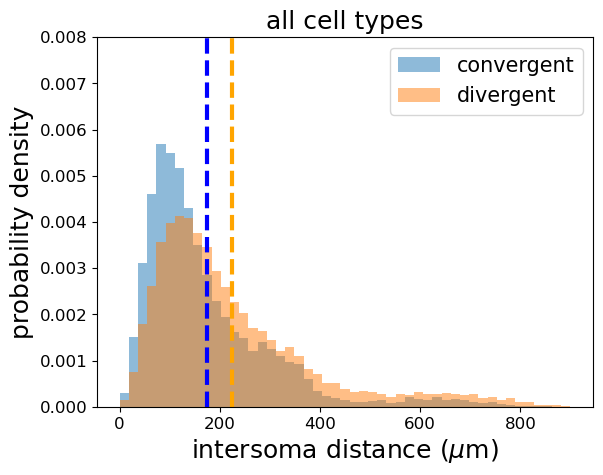

In [72]:
fig,ax = plt.subplots()
con_dists = con_dist_df[['distance']]
div_dists = div_dist_df[['distance']]
ax.hist(con_dists,density=True,bins=np.linspace(0,900,50),label='convergent',alpha=0.5)
ax.hist(div_dists,density=True,bins=np.linspace(0,900,50),label='divergent',alpha=0.5)
con_mean = np.mean(con_dists)
div_mean = np.mean(div_dists)
ax.set_title('all cell types',fontsize=18)
ax.vlines(con_mean,0,0.012,linestyle='--',color='blue',linewidth=3)
ax.vlines(div_mean,0,0.012,linestyle='--',color='orange',linewidth=3)
# # print(stats.ks_2samp(con_corrs_raw, div_corrs_raw))
# ax.set_title('raw data')
ax.tick_params(axis='x',labelsize=12)
ax.tick_params(axis='y',labelsize=12)
ax.set_xlabel(r'intersoma distance ($\mu$m)',fontsize=18)
ax.set_ylabel('probability density',fontsize=18)
# ax.set_xlim([-0.1,0.4])
ax.set_ylim([0,0.008])
plt.legend(fontsize=15)
plt.savefig('intersoma_dists_conDiv_allCellTypes.png',bbox_inches='tight',dpi=200)
plt.show()

In [73]:
L23toL5_df = df[ (df['cell_type_pre'] == 'L2/3') & (df['cell_type_post'] == 'L5')]
L23toL5_df

,pre_pt_root_id,post_pt_root_id,sum_size,index_pre,index_post,C,cell_type_pre,cell_type_post,distance
2,864691135155894884,864691136310417242,9404,2145,9470,0.040026,L2/3,L5,367.348259
3,864691135591041291,864691136310417242,25900,2091,9470,0.145264,L2/3,L5,365.472305
5,864691135582733933,864691136310417242,1364,3567,9470,-0.020131,L2/3,L5,237.055285
8,864691135591291659,864691136310417242,3976,2557,9470,0.030028,L2/3,L5,218.534351
10,864691135755884754,864691136310417242,9084,5503,9470,0.381670,L2/3,L5,263.611832
...,...,...,...,...,...,...,...,...,...
22822,864691135358995288,864691135684258290,5216,7108,4907,0.076891,L2/3,L5,194.424155
22823,864691136237644604,864691136389425783,356,3150,8011,0.212564,L2/3,L5,62.560295
22825,864691136237644604,864691135495347600,2460,3150,3933,0.118563,L2/3,L5,618.453069
22827,864691135428676144,864691135491116903,10184,5187,5945,0.052341,L2/3,L5,434.068822


In [74]:
L23toL5_df.to_csv('L23toL5_df.csv')
CSV_EDGELIST = 'L23toL5_df.csv'

In [75]:
graph = CSVEdgelistConverter(
    CSV_EDGELIST,
    "pre_pt_root_id",
    "post_pt_root_id"
).to_graph()

# Create the search engine.
E = GrandIsoExecutor(graph=graph)

In [76]:

con_motif = Motif("""
A -> C
B -> C
""")

con_results = E.find(con_motif)
n_con = len(con_results)

div_motif = Motif("""
B -> A
B -> C
""")

div_results = E.find(div_motif)
n_div = len(div_results)


In [77]:
# con_idcs = np.zeros((len(con_results_raw),2))
d = {}
d['pre_pt_root_id'] = np.zeros(2*len(con_results),dtype=np.int64)
d['post_pt_root_id'] = np.zeros(2*len(con_results),dtype=np.int64)
i = 0
for con_motif in con_results:
    aid = np.int64(con_motif['A'])
    bid = np.int64(con_motif['B'])
    cid = np.int64(con_motif['C'])
    d['pre_pt_root_id'][i] = aid
    d['pre_pt_root_id'][i+1] = bid
    d['post_pt_root_id'][i] = cid
    d['post_pt_root_id'][i+1] = cid
    i += 2
con_df = pd.DataFrame(data=d)
con_df

,pre_pt_root_id,post_pt_root_id
0,864691135155894884,864691136310417242
1,864691135591041291,864691136310417242
2,864691135155894884,864691136310417242
3,864691135582733933,864691136310417242
4,864691135155894884,864691136310417242
...,...,...
34155,864691135937286404,864691135954735880
34156,864691135851792071,864691135954735880
34157,864691136925601354,864691135954735880
34158,864691135851792071,864691135954735880


In [78]:
d = {}
d['pre_pt_root_id'] = np.zeros(2*len(div_results),dtype=np.int64)
d['post_pt_root_id'] = np.zeros(2*len(div_results),dtype=np.int64)
i = 0
for div_motif in div_results:
    aid = np.int64(div_motif['A'])
    bid = np.int64(div_motif['B'])
    cid = np.int64(div_motif['C'])
    d['post_pt_root_id'][i] = aid
    d['post_pt_root_id'][i+1] = cid
    d['pre_pt_root_id'][i] = bid
    d['pre_pt_root_id'][i+1] = bid
    i += 2
div_df = pd.DataFrame(data=d)
div_df

,pre_pt_root_id,post_pt_root_id
0,864691135155894884,864691136310417242
1,864691135155894884,864691135786340548
2,864691135155894884,864691136310417242
3,864691135155894884,864691135477010344
4,864691135155894884,864691136310417242
...,...,...
123495,864691135428676144,864691135324041372
123496,864691135428676144,864691135491116903
123497,864691135428676144,864691135565679447
123498,864691135428676144,864691135491116903


In [79]:
con_dist_df = con_df.merge(df,how='inner',on=['pre_pt_root_id','post_pt_root_id'])
con_dist_df

,pre_pt_root_id,post_pt_root_id,sum_size,index_pre,index_post,C,cell_type_pre,cell_type_post,distance
0,864691135155894884,864691136310417242,9404,2145,9470,0.040026,L2/3,L5,367.348259
1,864691135155894884,864691136310417242,9404,2145,9470,0.040026,L2/3,L5,367.348259
2,864691135155894884,864691136310417242,9404,2145,9470,0.040026,L2/3,L5,367.348259
3,864691135155894884,864691136310417242,9404,2145,9470,0.040026,L2/3,L5,367.348259
4,864691135155894884,864691136310417242,9404,2145,9470,0.040026,L2/3,L5,367.348259
...,...,...,...,...,...,...,...,...,...
34155,864691135468161164,864691136522741905,10368,323,1571,-0.003675,L2/3,L5,225.663238
34156,864691135502730562,864691135586214524,7812,368,4714,-0.109584,L2/3,L5,207.484901
34157,864691135502730562,864691135586214524,7812,368,4714,-0.109584,L2/3,L5,207.484901
34158,864691136124845606,864691135586214524,4156,7997,4714,0.094366,L2/3,L5,209.214491


In [80]:
div_dist_df = div_df.merge(df,how='inner',on=['pre_pt_root_id','post_pt_root_id'])
div_dist_df

,pre_pt_root_id,post_pt_root_id,sum_size,index_pre,index_post,C,cell_type_pre,cell_type_post,distance
0,864691135155894884,864691136310417242,9404,2145,9470,0.040026,L2/3,L5,367.348259
1,864691135155894884,864691136310417242,9404,2145,9470,0.040026,L2/3,L5,367.348259
2,864691135155894884,864691136310417242,9404,2145,9470,0.040026,L2/3,L5,367.348259
3,864691135155894884,864691136310417242,9404,2145,9470,0.040026,L2/3,L5,367.348259
4,864691135155894884,864691136310417242,9404,2145,9470,0.040026,L2/3,L5,367.348259
...,...,...,...,...,...,...,...,...,...
123495,864691135428676144,864691135491116903,10184,5187,5945,0.052341,L2/3,L5,434.068822
123496,864691135428676144,864691135491116903,10184,5187,5945,0.052341,L2/3,L5,434.068822
123497,864691135428676144,864691135491116903,10184,5187,5945,0.052341,L2/3,L5,434.068822
123498,864691135428676144,864691135491116903,10184,5187,5945,0.052341,L2/3,L5,434.068822


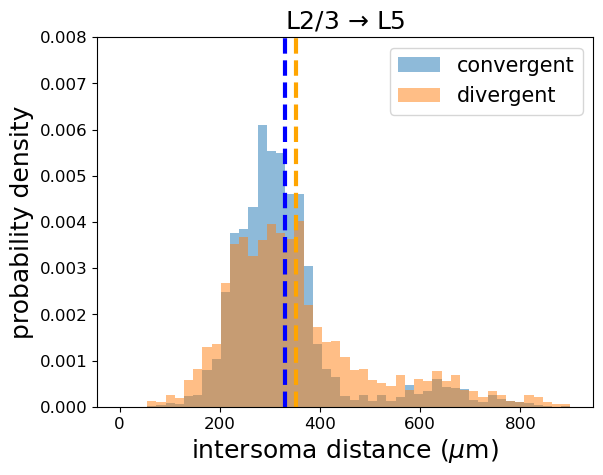

In [81]:
fig,ax = plt.subplots()
con_dists = con_dist_df[['distance']]
div_dists = div_dist_df[['distance']]
ax.set_title(r'L2/3 $\to$ L5',fontsize=18)
ax.hist(con_dists,density=True,bins=np.linspace(0,900,50),label='convergent',alpha=0.5)
ax.hist(div_dists,density=True,bins=np.linspace(0,900,50),label='divergent',alpha=0.5)
con_mean = np.mean(con_dists)
div_mean = np.mean(div_dists)
ax.vlines(con_mean,0,0.008,linestyle='--',color='blue',linewidth=3)
ax.vlines(div_mean,0,0.008,linestyle='--',color='orange',linewidth=3)
# # print(stats.ks_2samp(con_corrs_raw, div_corrs_raw))
# ax.set_title('raw data')
ax.tick_params(axis='x',labelsize=12)
ax.tick_params(axis='y',labelsize=12)
ax.set_xlabel(r'intersoma distance ($\mu$m)',fontsize=18)
ax.set_ylabel('probability density',fontsize=18)
# ax.set_xlim([-0.1,0.4])
ax.set_ylim([0,0.008])
plt.legend(fontsize=15)
plt.savefig('intersoma_dists_conDiv_L23to5.png',bbox_inches='tight',dpi=200)
plt.show()

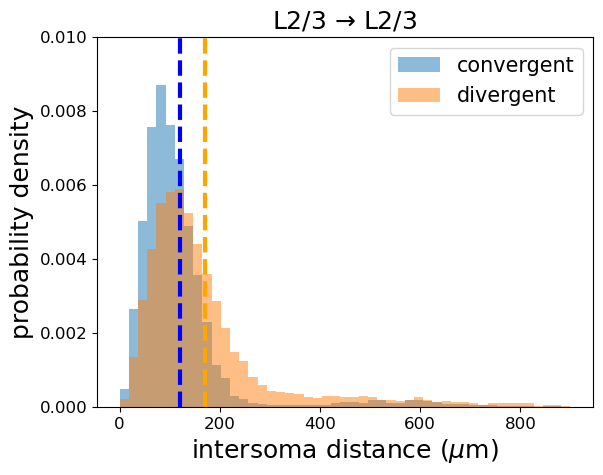

In [82]:
L23toL23_df = df[ (df['cell_type_pre'] == 'L2/3') & (df['cell_type_post'] == 'L2/3')]
# L23toL23_df
L23toL23_df.to_csv('L23toL23_df.csv')
CSV_EDGELIST = 'L23toL23_df.csv'
graph = CSVEdgelistConverter(
    CSV_EDGELIST,
    "pre_pt_root_id",
    "post_pt_root_id"
).to_graph()
# Create the search engine.
con_motif = Motif("""
A -> C
B -> C
""")
div_motif = Motif("""
B -> A
B -> C
""")
E = GrandIsoExecutor(graph=graph)
con_results = E.find(con_motif)
n_con = len(con_results)
div_results = E.find(div_motif)
n_div = len(div_results)
# con_idcs = np.zeros((len(con_results_raw),2))
d = {}
d['pre_pt_root_id'] = np.zeros(2*len(con_results),dtype=np.int64)
d['post_pt_root_id'] = np.zeros(2*len(con_results),dtype=np.int64)
i = 0
for con_motif in con_results:
    aid = np.int64(con_motif['A'])
    bid = np.int64(con_motif['B'])
    cid = np.int64(con_motif['C'])
    d['pre_pt_root_id'][i] = aid
    d['pre_pt_root_id'][i+1] = bid
    d['post_pt_root_id'][i] = cid
    d['post_pt_root_id'][i+1] = cid
    i += 2
con_df = pd.DataFrame(data=d)
# con_df
d = {}
d['pre_pt_root_id'] = np.zeros(2*len(div_results),dtype=np.int64)
d['post_pt_root_id'] = np.zeros(2*len(div_results),dtype=np.int64)
i = 0
for div_motif in div_results:
    aid = np.int64(div_motif['A'])
    bid = np.int64(div_motif['B'])
    cid = np.int64(div_motif['C'])
    d['post_pt_root_id'][i] = aid
    d['post_pt_root_id'][i+1] = cid
    d['pre_pt_root_id'][i] = bid
    d['pre_pt_root_id'][i+1] = bid
    i += 2
div_df = pd.DataFrame(data=d)
# div_df
con_dist_df = con_df.merge(df,how='inner',on=['pre_pt_root_id','post_pt_root_id'])
# con_dist_df
div_dist_df = div_df.merge(df,how='inner',on=['pre_pt_root_id','post_pt_root_id'])
# div_dist_df

fig,ax = plt.subplots()
con_dists = con_dist_df[['distance']]
div_dists = div_dist_df[['distance']]
ax.set_title(r'L2/3 $\to$ L2/3',fontsize=18)
ax.hist(con_dists,density=True,bins=np.linspace(0,900,50),label='convergent',alpha=0.5)
ax.hist(div_dists,density=True,bins=np.linspace(0,900,50),label='divergent',alpha=0.5)
con_mean = np.mean(con_dists)
div_mean = np.mean(div_dists)
ax.vlines(con_mean,0,0.01,linestyle='--',color='blue',linewidth=3)
ax.vlines(div_mean,0,0.01,linestyle='--',color='orange',linewidth=3)
# # print(stats.ks_2samp(con_corrs_raw, div_corrs_raw))
# ax.set_title('raw data')
ax.tick_params(axis='x',labelsize=12)
ax.tick_params(axis='y',labelsize=12)
ax.set_xlabel(r'intersoma distance ($\mu$m)',fontsize=18)
ax.set_ylabel('probability density',fontsize=18)
# ax.set_xlim([-0.1,0.4])
ax.set_ylim([0,0.01])
plt.legend(fontsize=15)
plt.savefig('intersoma_dists_conDiv_L23to23.png',bbox_inches='tight',dpi=200)
plt.show()

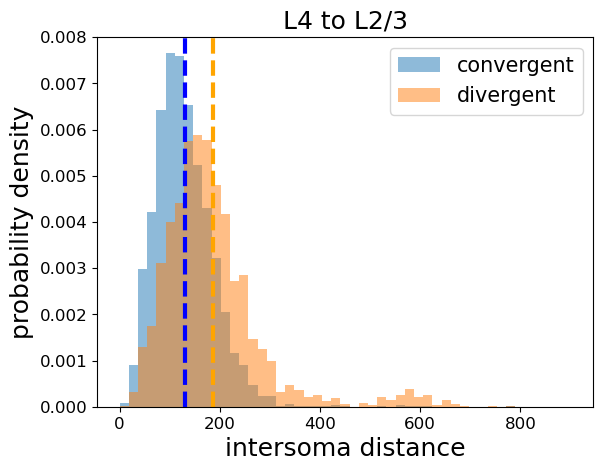

In [86]:
L4toL23_df = df[ (df['cell_type_pre'] == 'L4') & (df['cell_type_post'] == 'L2/3')]
# L23toL23_df
L4toL23_df.to_csv('L4toL23_df.csv')
CSV_EDGELIST = 'L4toL23_df.csv'
graph = CSVEdgelistConverter(
    CSV_EDGELIST,
    "pre_pt_root_id",
    "post_pt_root_id"
).to_graph()
# Create the search engine.
con_motif = Motif("""
A -> C
B -> C
""")
div_motif = Motif("""
B -> A
B -> C
""")
E = GrandIsoExecutor(graph=graph)
con_results = E.find(con_motif)
n_con = len(con_results)
div_results = E.find(div_motif)
n_div = len(div_results)
# con_idcs = np.zeros((len(con_results_raw),2))
d = {}
d['pre_pt_root_id'] = np.zeros(2*len(con_results),dtype=np.int64)
d['post_pt_root_id'] = np.zeros(2*len(con_results),dtype=np.int64)
i = 0
for con_motif in con_results:
    aid = np.int64(con_motif['A'])
    bid = np.int64(con_motif['B'])
    cid = np.int64(con_motif['C'])
    d['pre_pt_root_id'][i] = aid
    d['pre_pt_root_id'][i+1] = bid
    d['post_pt_root_id'][i] = cid
    d['post_pt_root_id'][i+1] = cid
    i += 2
con_df = pd.DataFrame(data=d)
# con_df
d = {}
d['pre_pt_root_id'] = np.zeros(2*len(div_results),dtype=np.int64)
d['post_pt_root_id'] = np.zeros(2*len(div_results),dtype=np.int64)
i = 0
for div_motif in div_results:
    aid = np.int64(div_motif['A'])
    bid = np.int64(div_motif['B'])
    cid = np.int64(div_motif['C'])
    d['post_pt_root_id'][i] = aid
    d['post_pt_root_id'][i+1] = cid
    d['pre_pt_root_id'][i] = bid
    d['pre_pt_root_id'][i+1] = bid
    i += 2
div_df = pd.DataFrame(data=d)
# div_df
con_dist_df = con_df.merge(df,how='inner',on=['pre_pt_root_id','post_pt_root_id'])
# con_dist_df
div_dist_df = div_df.merge(df,how='inner',on=['pre_pt_root_id','post_pt_root_id'])
# div_dist_df

fig,ax = plt.subplots()
con_dists = con_dist_df[['distance']]
div_dists = div_dist_df[['distance']]
ax.set_title('L4 to L2/3',fontsize=18)
ax.hist(con_dists,density=True,bins=np.linspace(0,900,50),label='convergent',alpha=0.5)
ax.hist(div_dists,density=True,bins=np.linspace(0,900,50),label='divergent',alpha=0.5)
con_mean = np.mean(con_dists)
div_mean = np.mean(div_dists)
ax.vlines(con_mean,0,0.008,linestyle='--',color='blue',linewidth=3)
ax.vlines(div_mean,0,0.008,linestyle='--',color='orange',linewidth=3)
# # print(stats.ks_2samp(con_corrs_raw, div_corrs_raw))
# ax.set_title('raw data')
ax.tick_params(axis='x',labelsize=12)
ax.tick_params(axis='y',labelsize=12)
ax.set_xlabel('intersoma distance',fontsize=18)
ax.set_ylabel('probability density',fontsize=18)
# ax.set_xlim([-0.1,0.4])
ax.set_ylim([0,0.008])
plt.legend(fontsize=15)
plt.savefig('intersoma_dists_conDiv_L4to23.png',bbox_inches='tight',dpi=200)
plt.show()